## 5.3 전이학습
- 많은 양의 데이터를 충분히 얻는 것은 쉽지 않음.
- 현실적인 어려움을 해결하는 방법 전이 학습
- 전이학습: 이미지넷처럼 아주 큰 데이터셋을 써서 훈련된 모델의 가중치를 가져와 우리가 해결하려는 과제에 맞게 보정해서 사용하는 것을 의미

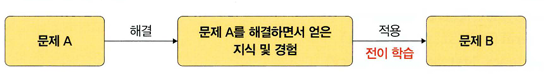

### 5.3.1 특성 추출 방법
- 특성 추출은 이미지넷 데이터셋으로 사전 훈련된 모델을 가져온 후 마지막에 완전연결층 부분만 새로 만드는 것.
- 학습할 때는 마지막 완전 연결층만 학습하고 나머지 계층은 학습하지 않음
  - 합성곱층: 합성솝층과 풀링층
  - 데이터 분류기(완전연결층): 추출된 특성을 입력받아 최종적으로 이미지에 대한 클래스를 분류
- 사용가능한 이미지 분류 모델
  - Xception
  - Inception V3
  - ResNet50
  - VGG16
  - VGG19
  - MobileNet

In [1]:
! pip install opencv-python

In [2]:
# 라이브러리 호출
import os
import time
import copy
import glob
import cv2   # 앞에서 설치한 OpenCV 라이브러리
import shutil

import torch
import torchvision   # 컴퓨터 비전(computer vision) 용도의 패키지
import torchvision.transforms as transforms   # 데이터 전처리를 위해 사용되는 패키지
import torchvision.models as models   # 다양한 파이토치 네트워크를 사용할 수 있도록 도와주는 패키지
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt


In [3]:
# 1. 저장소 전체를 clone
!git clone https://github.com/gilbutITbook/080289.git

# 2. 작업 디렉토리를 해당 폴더로 이동
%cd 080289/chap05/data/catanddog/

# 3. 파일 목록 확인
!ls

Cloning into '080289'...
remote: Enumerating objects: 2278, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 2278 (delta 4), reused 27 (delta 3), pack-reused 2246 (from 1)
Receiving objects: 100% (2278/2278), 330.30 MiB | 20.64 MiB/s, done.
Resolving deltas: 100% (13/13), done.
Updating files: 100% (2591/2591), done.
/content/080289/chap05/data/catanddog
test  train


In [4]:
# 이미지 데이터 전처리 방법 정의
data_path = '/content/080289/chap05/data/catanddog/train'   # 이미지 데이터가 위치한 경로 지정

transform=transforms.Compose(
    [
        transforms.Resize([256, 256]),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor()
])   # 1
train_dataset = torchvision.datasets.ImageFolder(
                data_path,
                transform=transform
)    # 2
train_loader = torch.utils.data.DataLoader(
               train_dataset,
               batch_size=32,
               num_workers=8,
               shuffle=True
)    # 3

print(len(train_dataset))


385


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


1. torchvision.transform: 이미지 데이터를 변환하여 모델(네트워크)의 입력으로 사용할 수 있게 변환

(a) Resize: 이미지의 크기를 조정 => 256x256 크기로 이미지 데이터를 조정

(b) RandomResizedCrop: 이미지를 랜덤한 크기 및 비율로 자름
  - Resize: 합성곱층을 통과하기 위해 이미지 크기를 조정하는 전처리 과정
  - RandomResizedCrop: 데이터 확장 용도로 사용 => 이미지를 랜덤한 비율로 자른 후 데이터 크기를 조정

(c) RandomHorizontalFlip: 이미지를 랜덤하게 수평으로 뒤집음

(d) ToTensor: 이미지 데이터를 텐서로 변환

2. datasets.ImageFolder: 데이터로더가 데이터를 불러올 대상과 방법(transform)을 정의

(a) 첫 번째 파라미터: 불러올 데이터가 위치한 경로

(b) transform: 이미지 데이터에 대한 전처리

3. 데이터로더가 ImageFolder(train_dataset)을 데이터로더에 할당할 때, 한 번에 불러올 데이터양을 결정하는 batch_size를 지정. 추가적으로 데이터를 무작위로 섞을(shuffle) 것인지 설정

(a) 첫 번째 파라미터: 데이터셋을 지정

(b) batch_size: 한 번에 불러올 데이터양을 결정하는 배치 크기를 설정

(c) num_workers: 데이터를 불러올 때 하위 프로세스를 몇 개 사용할지 설정 => 너무 많은 하위 프로세스 설정은 오류/메모리 부족 현상

(d) shuffle: 데이터를 무작위로 설정할지 지정
(shuffle=True: 데이터를 무작위로 섞어 랜덤)

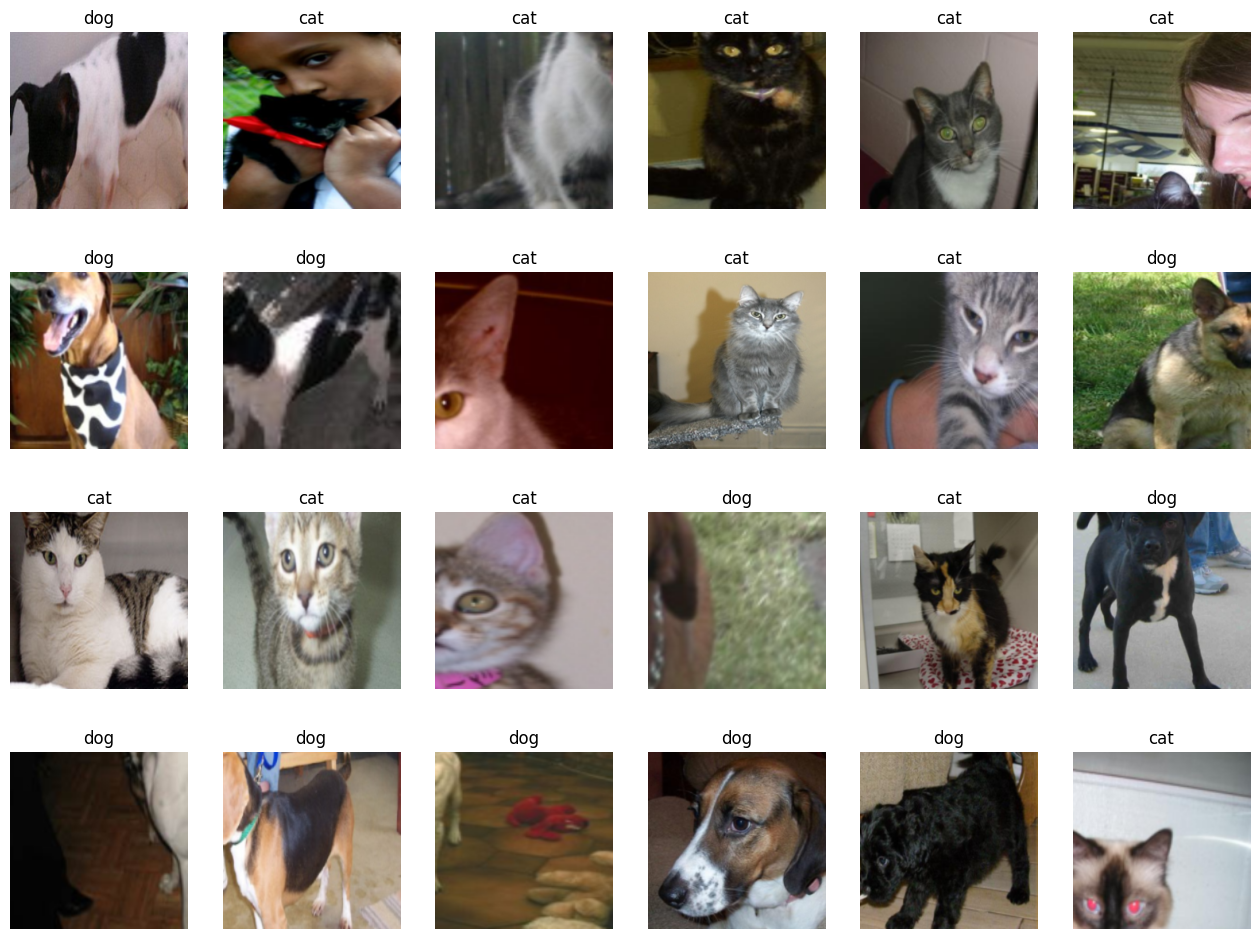

In [5]:
# 학습에 사용될 이미지 출력
samples, labels = next(iter(train_loader))   # 1
classes = {0:'cat', 1:'dog'}   # 개와 고양이에 대한 클래스로 구성
fig = plt.figure(figsize=(16, 24))
for i in range(24):   # 24개의 이미지 데이터 출력
    a = fig.add_subplot(4, 6, i+1)
    a.set_title(classes[labels[i].item()])   # 레이블 정보(클래스)를 함께 출력
    a.axis('off')
    a.imshow(np.transpose(samples[i].numpy(), (1, 2, 0)))   # 2
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)

1. 반복자를 사용하려면 iter(), next()가 필요
- iter(): 전달된 데이터의 반복자를 꺼내 반환
- next(): 그 반복자가 다음에 출력해야 할 요소를 반환
- iter()로 반복자를 구하고 그 반복자를 next()에 전달하여 차례대로 꺼낼 수 있음

2. np.transpose: 행과 열을 바꿈으로써 행렬의 차원을 바꿈
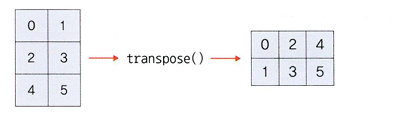

- 차원 변경 이유; 행렬의 내적 연산은 A행렬의 행과 B 행렬의 열의 수가 같아져야 내적이 가능
-> np.transpose()나 np.reshape() 등으로 차원을 조정

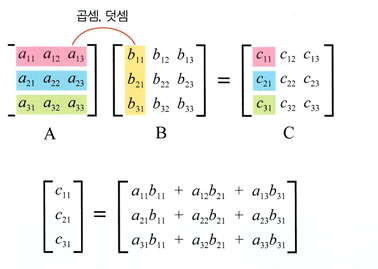

In [ ]:
# exam = np.arange(24).reshape(2, 3, 4)
# exam
# np.transpose(exam, (2, 1, 0))   # (2, 3, 4) 크기를 (4, 3, 2)로 변환

In [6]:
# 사전 훈련된 모델 내려받기
resnet18 = models.resnet18(pretrained=True)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 87.0MB/s]


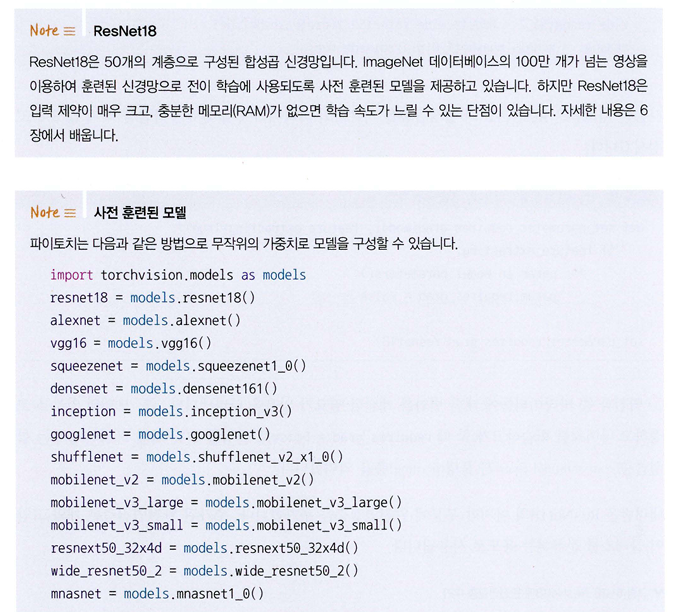

In [7]:
# 사전 훈련된 모델의 파라미터 학습 유무 지정
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

set_parameter_requires_grad(resnet18, feature_extracting=True)

- 역전파 중 파라미터들에 대한 변화를 계산할 필요가 없음 => 모델의 일부를 고정하고 나머지를 학습하고자 할 때 requires_grad = False로 설정

In [8]:
# ResNet18에 완전연결층 추가
resnet18.fc = nn.Linear(512, 2)   # 2는 클래스가 두 개라는 의미

In [9]:
# 모델의 파라미터 값 확인
for name, param in resnet18.named_parameters():
    if param.requires_grad:
       print(name, param.data)

fc.weight tensor([[-0.0113, -0.0418,  0.0263,  ...,  0.0204,  0.0206,  0.0365],
        [-0.0412, -0.0113,  0.0293,  ..., -0.0189,  0.0366, -0.0259]])
fc.bias tensor([-0.0290, -0.0263])


In [10]:
# 모델 객체 생성 및 손실 함수 정의
model = models.resnet18(pretrained=True)   # 모델의 객체 생성

for param in model.parameters():   # 모델의 합성곱층 가중치 고정
    param.requires_grad = False

model.fc = torch.nn.Linear(512, 2)
for param in model.fc.parameters():   # 완전연결층은 학습
    param.requires_grad = True

optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001)
cost = torch.nn.CrossEntropyLoss()   # 손실 함수 정의
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [11]:
# 모델 학습을 위한 함수 생성
def train_model(model, dataloaders, criterion, optimizer, device, num_epochs=13,
                is_train=True):
    since = time.time()   # 컴퓨터의 현재 시각을 구하는 함수
    acc_history = []
    loss_history = []
    best_acc = 0.0
    model.to(device)

    for epoch in range(num_epochs):   # 에포크(13)만큼 반복
        print("Epoch {}/{}".format(epoch, num_epochs-1))
        print('-' * 10)

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders:   # 데이터로더에 전달된 데이터만큼 반복
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()   # 기울기 0으로 설정
            outputs = model(inputs)   # 순전파 학습
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            loss.backward()   # 역전파 학습
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)   # 출력 결과와 레이블의 오차를 계산한 결과를 누적하여 저장
            running_corrects += torch.sum(preds == labels.data)   # 출력 결과와 레이블이 동일한지 확인한 결과를 누적하여 저장

        epoch_loss = running_loss / len(dataloaders.dataset)   # 평균 오차 계산
        epoch_acc = running_corrects.double() / len(dataloaders.dataset)   # 평균 정확도 계산

        print('Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))

        if epoch_acc > best_acc:
            best_acc = epoch_acc

        acc_history.append(epoch_acc.item())
        loss_history.append(epoch_loss)

        torch.save(model.state_dict(), os.path.join('/content/080289/chap05/data/catanddog/',
                   '{0:0=2d}.pth'.format(epoch)))   # 모델 재사용을 위해 저장해 둡니다.
        print()

    time_elapsed = time.time() - since    # 실행 시간(학습 시간)을 계산
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60,
                                                        time_elapsed % 60))
    print('Best Acc: {:.4f}'.format(best_acc))
    return acc_history, loss_history    # 모델의 정확도와 오차를 반환


In [12]:

# 파라미터 학습 결과를 옵티마이저에 전달
params_to_update = []
for name, param in resnet18.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)   # 파라미터 학습 결과를 저장
        print("\t", name)

optimizer = optim.Adam(params_to_update)   # 학습 결과를 옵티마이저에 전달

	 fc.weight
	 fc.bias


In [13]:
# 모델 학습
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()   # 손실 함수 지정
train_acc_hist, train_loss_hist = train_model(resnet18, train_loader, criterion,
                                              optimizer, device)

Epoch 0/12
----------
Loss: 0.5276 Acc: 0.7481

Epoch 1/12
----------
Loss: 0.3710 Acc: 0.8416

Epoch 2/12
----------
Loss: 0.3036 Acc: 0.8857

Epoch 3/12
----------
Loss: 0.2653 Acc: 0.9091

Epoch 4/12
----------
Loss: 0.2557 Acc: 0.8883

Epoch 5/12
----------
Loss: 0.2845 Acc: 0.8779

Epoch 6/12
----------
Loss: 0.2925 Acc: 0.8675

Epoch 7/12
----------
Loss: 0.2062 Acc: 0.9117

Epoch 8/12
----------
Loss: 0.2097 Acc: 0.9143

Epoch 9/12
----------
Loss: 0.2874 Acc: 0.8649

Epoch 10/12
----------
Loss: 0.1636 Acc: 0.9506

Epoch 11/12
----------
Loss: 0.2184 Acc: 0.9039

Epoch 12/12
----------
Loss: 0.2472 Acc: 0.8961

Training complete in 11m 20s
Best Acc: 0.9506


In [14]:
# 테스트 데이터 호출 및 전처리
test_path = '/content/080289/chap05/data/catanddog/test'

transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])

test_dataset = torchvision.datasets.ImageFolder(
    root=test_path,
    transform=transform
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=32,
    num_workers=1,
    shuffle=True
)

print(len(test_dataset))

98


In [15]:
# 테스트 데이터 평가 함수 생성
def eval_model(model, dataloaders, device):
    since = time.time()
    acc_history = []
    best_acc = 0.0

    saved_models = glob.glob('../chap05/data/catanddog/' + '*.pth')   # 1
    saved_models.sort()   # 불러온 .pth 파일들을 정렬
    print('saved_model:', saved_models)

    for model_path in saved_models:
        print('loading model:', model_path)

        model.load_state_dict(torch.load(model_path))
        model.eval()
        model.to(device)
        running_corrects = 0

        for inputs, labels in test_loader:   # 테스트 반복
            inputs = inputs.to(device)
            labels = labels.to(device)

            with torch.no_grad():   # autograd를 사용하지 않겠다는 의미
                outputs = model(inputs)   # 데이터를 모델에 적용한 결과를 outputs에 저장

            _, preds = torch.max(outputs.data, 1)   # 2
            preds[preds > 0.5] = 1    # torch.max로 출력된 값이 0.5보다 크면 올바르게 예측
            preds[preds <= 0.5] = 0   # torch.max로 출력된 값이 0.5보다 작으면 틀리게 예측
            running_corrects += preds.eq(labels.data.view_as(preds)).sum().item()   # 3

        epoch_acc = running_corrects.double() / len(dataloaders.dataset)   # 테스트 데이터의 정확도 계산
        print('Acc: {:.4f}'.format(epoch_acc))

        if epoch_acc > best_acc:
           best_acc = epoch_acc

        acc_history.append(epoch_acc.item())
        print()

    time_elapsed = time.time() - since
    print('Validation complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60,
                                                          time_elapsed % 60))
    print('Best Acc: {:.4f}'.format(best_acc))

    return acc_history   # 계산된 정확도 반환

1. glob: 현재 디렉터리에서 원하는 파일들만 추출하여 가져올 때 사용
2. torch.max: 주어진 텐서 배열의 최댓값이 들어 있는 index를 반환하는 함수
3. preds.eq(labels): preds 배열과 labels가 일치하는지 검사하는 용도.
- sum(): 모델의 예측 결과와 정답(레이블)이 일치하는 것들의 개수 합을 숫자로 출력

In [16]:
# 테스트 데이터를 평가 함수에 적용
val_acc_hist = eval_model(resnet18, test_loader, device)

saved_model: []
Validation complete in 0m 0s
Best Acc: 0.0000


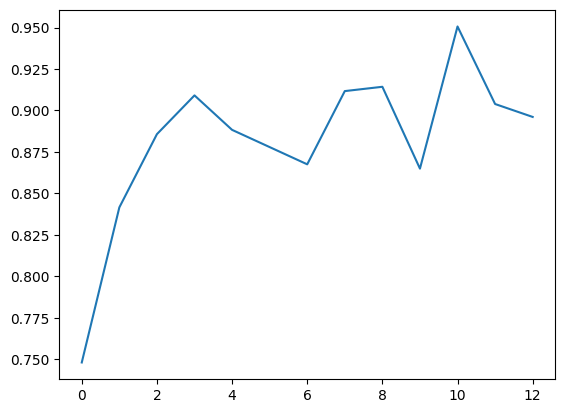

In [17]:
# 훈련과 테스트 데이터의 정확도를 그래프로 확인
plt.plot(train_acc_hist)
plt.plot(val_acc_hist)
plt.show()

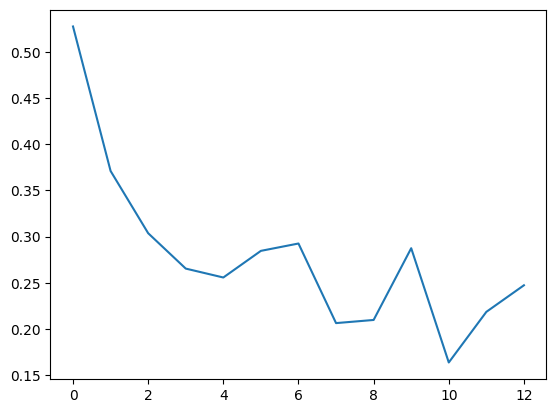

In [18]:
# 훈련 데이터의 오차에 대한 그래프 확인
plt.plot(train_loss_hist)
plt.show()

In [19]:
# 예측 이미지 출력을 위한 전처리 함수
def im_convert(tensor):
    image = tensor.clone().detach().numpy()   # 1
    image = image.transpose(1, 2, 0)
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
    image = image.clip(0, 1)   # 2
    return image

1. tensor.clone(): 기존 텐서의 내용을 복사한 텐서를 생성함.

- detach(): 기존 텐서에서 기울기가 전파되지 않는 텐서를 말하는데 tensor.detach()는 기존 텐서를 복사한 새로운 텐서를 생성하지만 기울기에는 영향을 주지 않음.

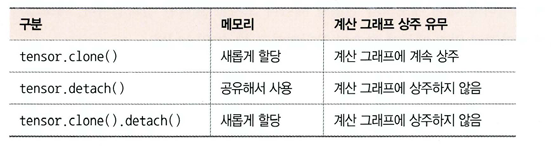


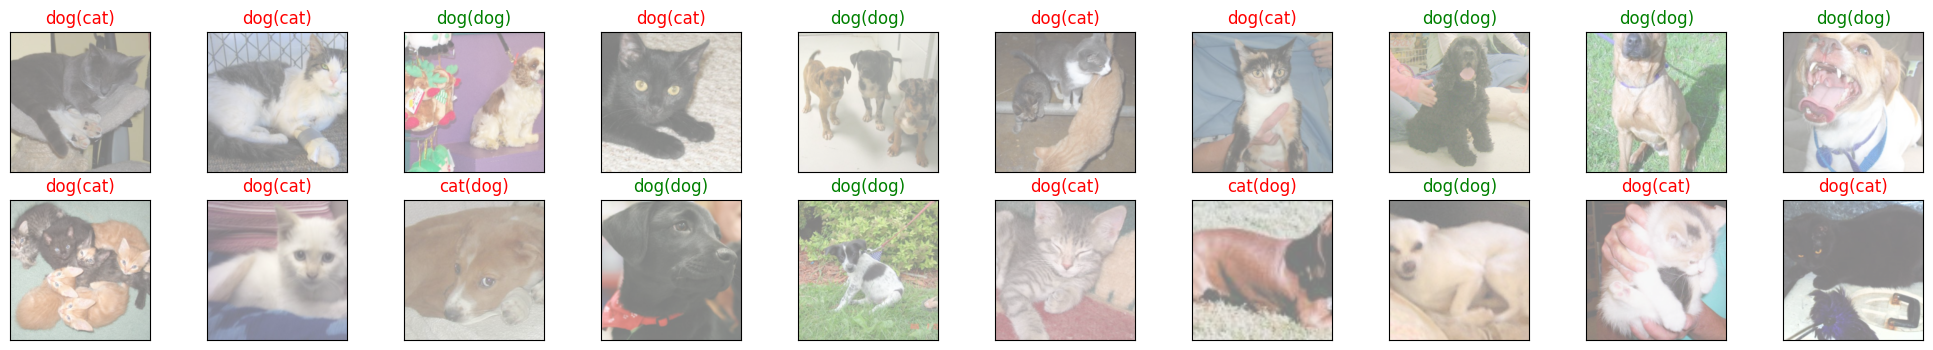

<Figure size 640x480 with 0 Axes>

In [20]:
# 개와 고양이 예측 결과 출력
classes = {0: 'cat', 1: 'dog'}   # 개와 고양이 두 개에 대한 레이블

dataiter = iter(test_loader)   # 테스트 데이터로더를 가져옵니다.
images,labels=next(dataiter)   # 테스트 데이터셋에서 이미지와 레이블을 분리하여 가져옵니다.
output = model(images)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])   # 1
    plt.imshow(im_convert(images[idx]))   # 이미지 출력을 위해 코드 5-20에서 정의한 im_convert 함수 적용
    ax.set_title(classes[labels[idx].item()])
    ax.set_title("{}({})".format(str(classes[preds[idx].item()]), str(classes[labels[idx].item()])),
                 color=("green" if preds[idx]==labels[idx] else "red"))   # 2
plt.show()
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)   # 3

1. add_subplot: 한 화면에 여러 개의 이미지 담기 위해 사용

(a) 첫 번째 파라미터: 행의 수, 이미지를 두 줄로 출력

(b) 두 번째 파라미터: 열의 수, 한 줄에 열 개의 이미지 출력

(c) 세 번째 파라미터: 인덱스, 행과 열을 기준으로 순차적으로 이미지 출력

(d) 네 번째 파라미터: 틱(tick) 삭제

2. classes[preds[idx].item()]: preds[idx].item() 값이 classes로 정의된 '0', '1' 중 어떤 값을 갖는지 판별하겠다는 의미 (0: 고양이, 1: 개)

3. Figure 안에서 서브플롯의 위치를 조정할 때 사용

### 5.3.2 미세 조정 기법: 특성 추출 기법에 더 나아가 사전 훈련된 모델과 합성곱층, 데이터 분류기의 가중치를 업데이트하여 훈련하는 방법, 목표 특성을 잘 추출했다는 전제하에 좋은 성능을 낼 수 있음.

- 특성이 잘못 추출되었다면 미세조정기법으로 새로운 이미지 데이터를 사용하여 네트워크의 가중치를 업데이트해서 특성을 다시 추출도 가능

-> 사전 학습된 모델을 목적에 맞게 재학습하거나 학습된 가중치를 일부를 재학습시키는 것.

  - 데이터셋이 크고 사전 훈련된 모델과 유사성이 작을 경우: 모델 전체를 재학습, 데이터셋 크기가 크기 떄문에 재학습시키는 것이 좋은 전략임.
  - 데이터셋이 크고 사전 훈련된 모델과 유사성이 클 경우: 합성곱층의 뒷부분(완전연결층과 가까운 부분)과 데이터 분류기를 학습, 데이터셋이 유사하기 때문에 전체를 학습시키는 것보다 강한 특징이 나타나는 합성곱층의 뒷부분과 데이터 분류기만 새로 학습해도 최적의 성능을 낼 수 있음.
  - 데이터셋이 작고 사전훈련된 모델과 유사성이 작을 경우: 합성곱층의 일부분과 데이터 분류기를 학습, 데이터가 적기 떄문에 일부 계층에 미세조정기법을 적용하더라고 효과가 없을 수 있음, 어디까지 새로 학습시켜야 할지 설정 필요.
  - 데이터셋이 작고 사전 훈련되 모델과 유사성이 클 경우: 데이터 분류기만 학습, 데이터가 적기 때문에 많은 계층에 미세조정 기법을 적용하면 과적합 발생 가능, 따라서 최종 분류기인 완전연결층에 대해서만 미세조정기법을 적용


-> 미세 조정은 파라미터 업데이트 과정에서 파라미터에 큰 변화를 주게 되면 과적합 문제가 발생가능하므로 정교하고 미세한 파라미터 업데이트가 중요